## Comparable Neighborhoods between Toronto and NYC

In [1]:
# import relevant liabraries
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
import geocoder
import folium # map rendering library
import json


import matplotlib


### Data work with Toronto

In [2]:
# Download Toronto Neighborhood Data
toronto_wiki_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
toronto_wiki_table = toronto_wiki_table[0]
columns = ['Postal Code', 'Borough', 'Neighborhood']
toronto_wiki_table.rename(columns={"Neighbourhood":"Neighborhood"}, inplace = True)
toronto_wiki_table.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# Filter out boroughs that are "Not assigned"
toronto_wiki_table = toronto_wiki_table[toronto_wiki_table["Borough"]!="Not assigned"]
toronto_wiki_table.reset_index(drop=True, inplace=True)
toronto_wiki_table.shape

(103, 3)

In [4]:
print("There are {} Boroughs and {} Neighborhoods in Toronto"
          .format(len(toronto_wiki_table["Borough"].unique()),
                  len(toronto_wiki_table["Neighborhood"].unique()))) 

There are 10 Boroughs and 99 Neighborhoods in Toronto


In [5]:
# Use geopy library to get latitude and longitude values of each Borough
latitude=[]
longitude=[]
for code in toronto_wiki_table["Postal Code"]:
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
        print(code, g.latlng)
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])


In [6]:
## create table based on postal code and lat and long
postal_code = list(toronto_wiki_table["Postal Code"])
toronto_lat_lng = pd.DataFrame([postal_code,latitude,longitude]).transpose()
toronto_lat_lng.columns = ["Postal Code", "Latitude", "Longitude"]
toronto_lat_lng.head()

,Postal Code,Latitude,Longitude
0,M3A,43.7525,-79.3299
1,M4A,43.7306,-79.3131
2,M5A,43.6551,-79.3626
3,M6A,43.7233,-79.4504
4,M7A,43.6625,-79.3919


In [7]:
## Join the toronto_wiki_table and toronto_lat_lng tables
toronto_geo_data = toronto_wiki_table.merge(toronto_lat_lng, how = 'left'
                                            ,left_on='Postal Code', right_on='Postal Code')

borough_list = ['Downtown Toronto']
toronto_geo_data = toronto_geo_data[toronto_geo_data.Borough.isin(borough_list)]

list(toronto_geo_data['Borough'].unique())

['Downtown Toronto']

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors



#let's plot this these on a map
address = 'Toronto, Ontario'

tor_boroughs = list(toronto_geo_data['Borough'].unique())

geolocator = Nominatim(user_agent='toronto')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
colors_array = cm.rainbow(np.linspace(0,1, len(tor_boroughs)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

                          
map_toronto = folium.Map(location=[latitude,longitude], zoom_start=12)
# add markers to map

for lat, lng, borough, neighborhood in zip(toronto_geo_data['Latitude']
                                           , toronto_geo_data['Longitude']
                                           , toronto_geo_data['Borough']
                                           , toronto_geo_data['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        
        folium.CircleMarker(
            [lat,lng],
            radius =5,
            popup = label,
            color = rainbow[tor_boroughs.index(borough)-1],
            fill = True).add_to(map_toronto)
map_toronto



## Now that we have the neighborhoods data in Toronto, time to get venue info from each neighborhood using Foursquare API

In [9]:
# Use Foursquare API to explore vendors around each neighborhood
CLIENT_ID = 'AWKEEWMDKNAWJBUM2OLPLVSCBJDKAEHSQKINKOO3N2GPWMI0' # your Foursquare ID
CLIENT_SECRET = 'HH20YAAJBL0FFBQWEQAJSW4DTPYGQ40ZWIEGFB34A4RKMLXG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AWKEEWMDKNAWJBUM2OLPLVSCBJDKAEHSQKINKOO3N2GPWMI0
CLIENT_SECRET:HH20YAAJBL0FFBQWEQAJSW4DTPYGQ40ZWIEGFB34A4RKMLXG


In [10]:
# This function is used to query FourSquare data based on lists of names, lat, long and radius
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [11]:
# Query venues data from each neighborhood using FourSquare
toronto_venues = getNearbyVenues(names = toronto_geo_data['Neighborhood'],
                                latitudes = toronto_geo_data['Latitude'],
                                longitudes = toronto_geo_data['Longitude']
                                )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [12]:
# Let's take a look at the data set
print(toronto_venues.shape)
toronto_venues.head(5)

(1248, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65512,-79.36264,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65512,-79.36264,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65512,-79.36264,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.65512,-79.36264,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
4,"Regent Park, Harbourfront",43.65512,-79.36264,Body Blitz Spa East,43.654735,-79.359874,Spa


In [13]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,60,60,60,60,60,60
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",76,76,76,76,76,76
Central Bay Street,76,76,76,76,76,76
Christie,11,11,11,11,11,11
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",58,58,58,58,58,58


In [14]:
print('There are {} unique categories'.format(len(toronto_venues['Venue Category'].unique())))

There are 196 unique categories


In [15]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
column_location = list(toronto_onehot.columns).index('Neighborhood')

fixed_columns =  list(toronto_onehot.columns)
fixed_columns.remove('Neighborhood')

fixed_columns = ['Neighborhood']+ fixed_columns
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,Church and Wellesley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1244,Church and Wellesley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1245,Church and Wellesley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1246,Church and Wellesley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.016667
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,...,0.013158,0.000000,0.013158,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.013158
2,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.013158,0.013158,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.013158,0.013158,0.013158,0.000000,0.000000,0.00,0.000000
3,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Church and Wellesley,0.012658,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.00,0.012658
5,"Commerce Court, Victoria Hotel",0.000000,0.030000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.010000
6,"First Canadian Place, Underground city",0.000000,0.030000,0.000000,0.000000,0.010000,0.000000,0.000000,0.030000,0.000000,...,0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000
7,"Garden District, Ryerson",0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000,0.000000,0.000000,0.00,0.000000
8,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.00,0.000000
9,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,...,0.000000,0.052632,0.000000,0.000000,0.035088,0.017544,0.000000,0.000000,0.00,0.000000


In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
## Let's look at most common venues per Neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,Coffee Shop,Beer Bar,Farmers Market,Seafood Restaurant,Restaurant
1,"CN Tower, King and Spadina, Railway Lands, Har...",Italian Restaurant,Café,Coffee Shop,Bar,Park
2,Central Bay Street,Coffee Shop,Clothing Store,Plaza,Hotel,Bookstore
3,Christie,Café,Grocery Store,Coffee Shop,Playground,Italian Restaurant
4,Church and Wellesley,Coffee Shop,Gay Bar,Restaurant,Japanese Restaurant,Café


## Time to do some cluster analysis with just the Toronto Data

In [19]:
from sklearn.cluster import KMeans

# Using the elbow method, figure out how many clusters there should be
distortions = []
K = range(1,20)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)
    

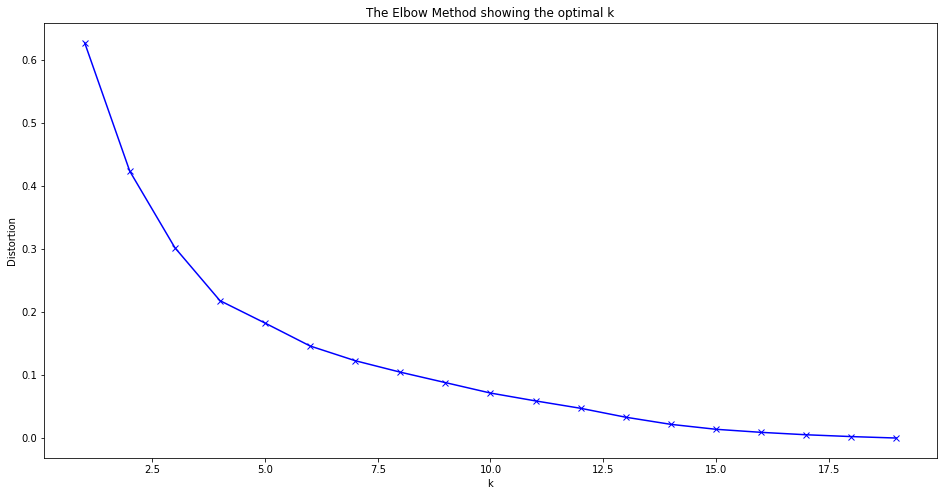

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
# at K = 6, we see a change in slope, so let's use that
kcluster = 6
kmeans = KMeans(n_clusters=kcluster, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_

array([4, 1, 4, 3, 4, 4, 4, 4, 4, 1, 5, 0, 4, 2, 4, 1, 4, 4, 1])

In [22]:
neighborhoods_venues_sorted.insert(0,'Cluster Label', kmeans.labels_)

toronto_merged = toronto_geo_data.copy()
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted, how = 'left'
                                     ,left_on = 'Neighborhood', right_on='Neighborhood')

toronto_merged.dropna(inplace = True)
toronto_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6551,-79.3626,0,Coffee Shop,Breakfast Spot,Yoga Studio,Bakery,Italian Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6625,-79.3919,5,Coffee Shop,Sandwich Place,Mediterranean Restaurant,Theater,Portuguese Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6574,-79.378,4,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant
3,M5C,Downtown Toronto,St. James Town,43.6522,-79.3759,4,Coffee Shop,Cocktail Bar,Cosmetics Shop,Café,Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.6454,-79.3731,4,Coffee Shop,Beer Bar,Farmers Market,Seafood Restaurant,Restaurant
5,M5G,Downtown Toronto,Central Bay Street,43.6561,-79.3849,4,Coffee Shop,Clothing Store,Plaza,Hotel,Bookstore
6,M6G,Downtown Toronto,Christie,43.6687,-79.4207,3,Café,Grocery Store,Coffee Shop,Playground,Italian Restaurant
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.6497,-79.3826,4,Coffee Shop,Hotel,Café,Restaurant,Gym
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.6429,-79.3808,4,Coffee Shop,Hotel,Plaza,Restaurant,Japanese Restaurant
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.6471,-79.3815,4,Coffee Shop,Hotel,Café,Restaurant,Salad Place


In [23]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kcluster)
ys = [i + x + (i*x)**2 for i in range(kcluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Now let's prepare the NYC data


In [24]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
response = requests.get(url)

print('Data downloaded!')

Data downloaded!


In [25]:
newyork_data = response.json()
nyc_neighborhoods_data = newyork_data['features']

In [26]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhoods_data:
    borough = nyc_neighborhood_name = data['properties']['borough'] 
    nyc_neighborhood_name = data['properties']['name']
        
    nyc_neighborhood_latlon = data['geometry']['coordinates']
    nyc_neighborhood_lat = nyc_neighborhood_latlon[1]
    nyc_neighborhood_lon = nyc_neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': nyc_neighborhood_name,
                                          'Latitude': nyc_neighborhood_lat,
                                          'Longitude': nyc_neighborhood_lon}, ignore_index=True)

In [27]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [28]:
borough_list = ['Manhattan']
nyc_neighborhoods = nyc_neighborhoods[nyc_neighborhoods.Borough.isin(borough_list)]

nyc_neighborhoods




,Borough,Neighborhood,Latitude,Longitude
6,Manhattan,Marble Hill,40.876551,-73.910660
100,Manhattan,Chinatown,40.715618,-73.994279
101,Manhattan,Washington Heights,40.851903,-73.936900
102,Manhattan,Inwood,40.867684,-73.921210
103,Manhattan,Hamilton Heights,40.823604,-73.949688
104,Manhattan,Manhattanville,40.816934,-73.957385
105,Manhattan,Central Harlem,40.815976,-73.943211
106,Manhattan,East Harlem,40.792249,-73.944182
107,Manhattan,Upper East Side,40.775639,-73.960508
108,Manhattan,Yorkville,40.775930,-73.947118


In [29]:
address = 'New York City, NY'

nyc_boroughs = list(nyc_neighborhoods['Borough'].unique())
colors_array = cm.rainbow(np.linspace(0,1, len(nyc_boroughs)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
geolocator = Nominatim(user_agent="ny_explorer")
nyc_location = geolocator.geocode(address)
nyc_latitude = nyc_location.latitude
nyc_longitude = nyc_location.longitude


print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.6534817, -79.3839347.


In [31]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=10)


# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], nyc_neighborhoods['Longitude'], nyc_neighborhoods['Borough'], nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[nyc_boroughs.index(borough)-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork


## Now that we have the neighborhoods data in Manhattan, time to get venue info from each neighborhood using Foursquare API

In [32]:
# Use Foursquare API to explore vendors around each neighborhood
CLIENT_ID = 'AWKEEWMDKNAWJBUM2OLPLVSCBJDKAEHSQKINKOO3N2GPWMI0' # your Foursquare ID
CLIENT_SECRET = 'HH20YAAJBL0FFBQWEQAJSW4DTPYGQ40ZWIEGFB34A4RKMLXG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AWKEEWMDKNAWJBUM2OLPLVSCBJDKAEHSQKINKOO3N2GPWMI0
CLIENT_SECRET:HH20YAAJBL0FFBQWEQAJSW4DTPYGQ40ZWIEGFB34A4RKMLXG


In [33]:
# Query venues data from each neighborhood using FourSquare
nyc_venues = getNearbyVenues(names = nyc_neighborhoods['Neighborhood'],
                                latitudes = nyc_neighborhoods['Latitude'],
                                longitudes = nyc_neighborhoods['Longitude']
                                )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [34]:
# Let's take a look at the data set
print(nyc_venues.shape)
nyc_venues.head(5)

(3219, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [282]:
nyc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,66,66,66,66,66,66
Carnegie Hill,86,86,86,86,86,86
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40
East Village,100,100,100,100,100,100


In [35]:
print('There are {} unique categories'.format(len(nyc_venues['Venue Category'].unique())))

There are 323 unique categories


In [36]:
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood']
column_location = list(nyc_onehot.columns).index('Neighborhood')

fixed_columns =  list(nyc_onehot.columns)
fixed_columns.remove('Neighborhood')

fixed_columns = ['Neighborhood']+ fixed_columns
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214,Hudson Yards,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3215,Hudson Yards,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3216,Hudson Yards,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3217,Hudson Yards,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.00,0.000000,0.000000
1,Carnegie Hill,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.011628,0.000000,0.011628,...,0.00,0.023256,0.000000,0.000000,0.000000,0.011628,0.034884,0.00,0.011628,0.034884
2,Central Harlem,0.000000,0.00,0.065217,0.043478,0.00,0.000000,0.000000,0.021739,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,Chelsea,0.000000,0.00,0.000000,0.040000,0.00,0.000000,0.000000,0.050000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.010000,0.000000
4,Chinatown,0.000000,0.00,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000
5,Civic Center,0.000000,0.00,0.000000,0.030000,0.01,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.01,0.000000,0.040000
6,Clinton,0.000000,0.00,0.000000,0.050000,0.00,0.000000,0.000000,0.010000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.00,0.000000,0.000000
7,East Harlem,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,East Village,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.010000,0.010000,0.000000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.040000,0.010000,0.01,0.000000,0.000000
9,Financial District,0.000000,0.00,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.010000,0.000000


In [38]:
## Let's look at most common venues per Neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

nyc_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site
1,Carnegie Hill,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center
2,Central Harlem,African Restaurant,Bar,French Restaurant,American Restaurant,Chinese Restaurant
3,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Ice Cream Shop
4,Chinatown,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant


## Time to do some cluster analysis with just the NYC Data

In [42]:
# Using the elbow method, figure out how many clusters there should be
nyc_distortions = []
K = range(1,20)
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood',1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(nyc_grouped_clustering)
    nyc_distortions.append(kmeans.inertia_)

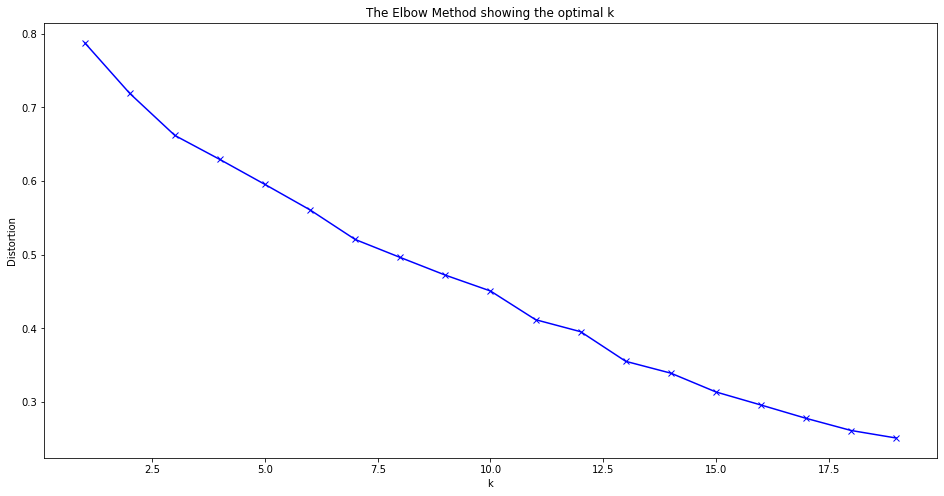

In [43]:
plt.figure(figsize=(16,8))
plt.plot(K, nyc_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [44]:
# at K = 6, we see a change in slope, so let's use that
nyc_kcluster = 6
kmeans = KMeans(n_clusters=nyc_kcluster, random_state=0).fit(nyc_grouped_clustering)
kmeans.labels_

array([4, 1, 3, 4, 3, 4, 4, 2, 3, 1, 1, 3, 1, 1, 4, 2, 1, 4, 1, 3, 3, 2,
       5, 4, 4, 2, 4, 1, 1, 1, 0, 1, 4, 2, 2, 4, 1, 2, 1, 1])

In [46]:
nyc_neighborhoods_venues_sorted.insert(0,'Cluster Label', kmeans.labels_)

nyc_merged = nyc_neighborhoods.copy()
nyc_merged = nyc_merged.merge(nyc_neighborhoods_venues_sorted, how = 'left'
                                     ,left_on = 'Neighborhood', right_on='Neighborhood')

nyc_merged.dropna(inplace = True)
nyc_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,5,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio
1,Manhattan,Chinatown,40.715618,-73.994279,3,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Café,Bakery,Grocery Store,Latin American Restaurant,Deli / Bodega
3,Manhattan,Inwood,40.867684,-73.921210,2,Mexican Restaurant,Lounge,Restaurant,Café,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Cocktail Bar
5,Manhattan,Manhattanville,40.816934,-73.957385,2,Seafood Restaurant,Coffee Shop,Bar,Deli / Bodega,Italian Restaurant
6,Manhattan,Central Harlem,40.815976,-73.943211,3,African Restaurant,Bar,French Restaurant,American Restaurant,Chinese Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,2,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Latin American Restaurant
8,Manhattan,Upper East Side,40.775639,-73.960508,4,Exhibit,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center
9,Manhattan,Yorkville,40.775930,-73.947118,1,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega


In [48]:

map_clusters = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(nyc_kcluster)
ys = [i + x + (i*x)**2 for i in range(nyc_kcluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Now perform the analysis on Toronto and NYC data together to find similar groups

In [86]:
toronto_grouped["City"] = "Toronto"
nyc_grouped["City"] = "NY"


fixed_columns =  list(toronto_grouped.columns)
fixed_columns.remove('City')

fixed_columns = ['City']+ fixed_columns
toronto_grouped = toronto_grouped[fixed_columns]

fixed_columns =  list(nyc_grouped.columns)
fixed_columns.remove('City')

fixed_columns = ['City']+ fixed_columns
nyc_grouped = nyc_grouped[fixed_columns]


nyc_tor_grouped = pd.concat([toronto_grouped, nyc_grouped])
nyc_tor_grouped=nyc_tor_grouped.fillna(0)
nyc_tor_grouped

,City,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Travel & Transport,Turkish Restaurant,Udon Restaurant,Used Bookstore,Venezuelan Restaurant,Video Store,Volleyball Court,Waterfront,Whisky Bar
0,Toronto,Berczy Park,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
1,Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
2,Toronto,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.013158,0.013158,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
3,Toronto,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
4,Toronto,Church and Wellesley,0.012658,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
5,Toronto,"Commerce Court, Victoria Hotel",0.000000,0.030000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
6,Toronto,"First Canadian Place, Underground city",0.000000,0.030000,0.000000,0.000000,0.010000,0.000000,0.000000,0.030000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
7,Toronto,"Garden District, Ryerson",0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
8,Toronto,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000
9,Toronto,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000


In [95]:
nyc_tor_grouped.shape[0]

59

In [129]:
## Let's look at most common venues per Neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City', 'Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_tor_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

nyc_tor_neighborhoods_venues_sorted['City'] = nyc_tor_grouped['City']
nyc_tor_neighborhoods_venues_sorted['Neighborhood'] = nyc_tor_grouped['Neighborhood']


for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(nyc_tor_grouped.iloc[ind, 1:], num_top_venues)

    
nyc_tor_neighborhoods_venues_sorted

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Toronto,Berczy Park,Coffee Shop,Farmers Market,Breakfast Spot,Cocktail Bar,Seafood Restaurant
1,Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",Italian Restaurant,Coffee Shop,Café,Park,Bar
2,Toronto,Central Bay Street,Coffee Shop,Clothing Store,Restaurant,Middle Eastern Restaurant,Sandwich Place
3,Toronto,Christie,Café,Grocery Store,Italian Restaurant,Candy Store,Athletics & Sports
4,Toronto,Church and Wellesley,Coffee Shop,Japanese Restaurant,Restaurant,Gay Bar,Café
5,Toronto,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Hotel,Café,Japanese Restaurant
6,Toronto,"First Canadian Place, Underground city",Coffee Shop,Hotel,Café,Restaurant,Gym
7,Toronto,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop
8,Toronto,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Hotel,Restaurant,Japanese Restaurant,Plaza
9,Toronto,"Kensington Market, Chinatown, Grange Park",Café,Coffee Shop,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar


In [130]:
# Using the elbow method, figure out how many clusters there should be
distortions = []
K = range(1,20)
nyc_tor_grouped_clustering = nyc_tor_grouped.drop(['City','Neighborhood'],1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(nyc_tor_grouped_clustering)
    distortions.append(kmeans.inertia_)

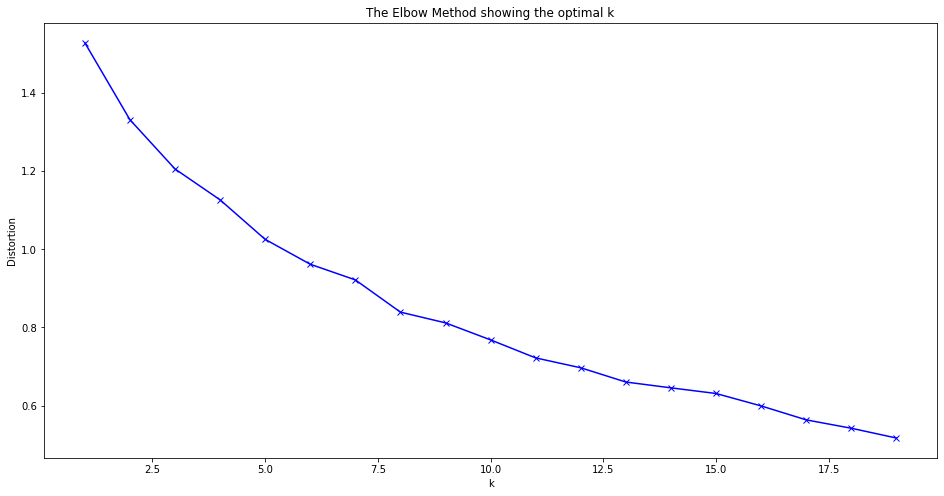

In [131]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [132]:
# at K = 8, we see a change in slope, so let's use that
nyc_tor_kcluster = 8
kmeans = KMeans(n_clusters=nyc_tor_kcluster, random_state=0).fit(nyc_tor_grouped_clustering)
kmeans.labels_

array([0, 6, 0, 5, 0, 0, 0, 0, 0, 2, 4, 4, 0, 3, 0, 2, 0, 0, 2, 1, 6, 1,
       1, 1, 1, 1, 2, 6, 0, 1, 6, 6, 2, 1, 2, 6, 1, 6, 2, 1, 2, 1, 1, 1,
       2, 1, 6, 1, 6, 7, 1, 6, 2, 6, 1, 6, 2, 6, 6])

In [133]:
nyc_tor_neighborhoods_venues_sorted.insert(0,'Cluster Label', kmeans.labels_)

toronto_geo_data["City"] = "Toronto"
nyc_neighborhoods["City"] = "NY"

nyc_tor_merged = pd.concat([toronto_geo_data, nyc_neighborhoods], keys=['Tor', 'NYC'])
nyc_tor_merged = nyc_tor_merged.merge(nyc_tor_neighborhoods_venues_sorted, how = 'left'
                                     ,left_on = ['City','Neighborhood'], right_on=['City','Neighborhood'])


nyc_tor_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6551,-79.3626,Toronto,4,Coffee Shop,Breakfast Spot,Bakery,Distribution Center,Park
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6625,-79.3919,Toronto,4,Coffee Shop,Sandwich Place,Bank,Park,Burrito Place
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6574,-79.378,Toronto,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop
3,M5C,Downtown Toronto,St. James Town,43.6522,-79.3759,Toronto,0,Coffee Shop,Cocktail Bar,Gastropub,Cosmetics Shop,Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.6454,-79.3731,Toronto,0,Coffee Shop,Farmers Market,Breakfast Spot,Cocktail Bar,Seafood Restaurant
5,M5G,Downtown Toronto,Central Bay Street,43.6561,-79.3849,Toronto,0,Coffee Shop,Clothing Store,Restaurant,Middle Eastern Restaurant,Sandwich Place
6,M6G,Downtown Toronto,Christie,43.6687,-79.4207,Toronto,5,Café,Grocery Store,Italian Restaurant,Candy Store,Athletics & Sports
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.6497,-79.3826,Toronto,0,Coffee Shop,Hotel,Café,Restaurant,Gym
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.6429,-79.3808,Toronto,0,Coffee Shop,Hotel,Restaurant,Japanese Restaurant,Plaza
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.6471,-79.3815,Toronto,0,Coffee Shop,Hotel,Restaurant,Café,American Restaurant


In [134]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 0, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,"Garden District, Ryerson",Toronto,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop
3,St. James Town,Toronto,0,Coffee Shop,Cocktail Bar,Gastropub,Cosmetics Shop,Restaurant
4,Berczy Park,Toronto,0,Coffee Shop,Farmers Market,Breakfast Spot,Cocktail Bar,Seafood Restaurant
5,Central Bay Street,Toronto,0,Coffee Shop,Clothing Store,Restaurant,Middle Eastern Restaurant,Sandwich Place
7,"Richmond, Adelaide, King",Toronto,0,Coffee Shop,Hotel,Café,Restaurant,Gym
8,"Harbourfront East, Union Station, Toronto Islands",Toronto,0,Coffee Shop,Hotel,Restaurant,Japanese Restaurant,Plaza
9,"Toronto Dominion Centre, Design Exchange",Toronto,0,Coffee Shop,Hotel,Restaurant,Café,American Restaurant
10,"Commerce Court, Victoria Hotel",Toronto,0,Coffee Shop,Restaurant,Hotel,Café,Japanese Restaurant
15,Stn A PO Boxes,Toronto,0,Coffee Shop,Hotel,Restaurant,Asian Restaurant,Bar
17,"First Canadian Place, Underground city",Toronto,0,Coffee Shop,Hotel,Café,Restaurant,Gym


In [135]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 1, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
19,Marble Hill,NY,1,Gym,Discount Store,Coffee Shop,Sandwich Place,Video Game Store
20,Chinatown,NY,1,Chinese Restaurant,Dessert Shop,Cocktail Bar,Bakery,American Restaurant
25,Central Harlem,NY,1,African Restaurant,Bar,French Restaurant,Cosmetics Shop,American Restaurant
27,Upper East Side,NY,1,Exhibit,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center
30,Roosevelt Island,NY,1,Deli / Bodega,Playground,Cosmetics Shop,Plaza,Pizza Place
32,Lincoln Square,NY,1,Plaza,Italian Restaurant,Concert Hall,Café,Performing Arts Venue
33,Clinton,NY,1,Theater,American Restaurant,Gym / Fitness Center,Gym,Cocktail Bar
34,Midtown,NY,1,Hotel,Bakery,Clothing Store,Coffee Shop,Steakhouse
35,Murray Hill,NY,1,Japanese Restaurant,American Restaurant,Hotel,Sandwich Place,Gym / Fitness Center
36,Chelsea,NY,1,Coffee Shop,Art Gallery,American Restaurant,Bakery,Italian Restaurant


In [136]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 2, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,"University of Toronto, Harbord",Toronto,2,Café,Coffee Shop,Bookstore,Bakery,Bar
12,"Kensington Market, Chinatown, Grange Park",Toronto,2,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar
16,"St. James Town, Cabbagetown",Toronto,2,Coffee Shop,Café,Restaurant,Pizza Place,Park
21,Washington Heights,NY,2,Café,Bakery,Grocery Store,Park,Supermarket
22,Inwood,NY,2,Mexican Restaurant,Café,Restaurant,Lounge,Bakery
23,Hamilton Heights,NY,2,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega
24,Manhattanville,NY,2,Coffee Shop,Seafood Restaurant,Park,Mexican Restaurant,Deli / Bodega
26,East Harlem,NY,2,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Sandwich Place
39,Lower East Side,NY,2,Chinese Restaurant,Pharmacy,Pizza Place,Art Gallery,Ramen Restaurant
45,Morningside Heights,NY,2,Park,American Restaurant,Coffee Shop,Bookstore,Burger Joint


In [137]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 3, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,Rosedale,Toronto,3,Bike Trail,Tennis Court,Playground,Park,Shop & Service


In [138]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 4, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Regent Park, Harbourfront",Toronto,4,Coffee Shop,Breakfast Spot,Bakery,Distribution Center,Park
1,"Queen's Park, Ontario Provincial Government",Toronto,4,Coffee Shop,Sandwich Place,Bank,Park,Burrito Place


In [139]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 5, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Christie,Toronto,5,Café,Grocery Store,Italian Restaurant,Candy Store,Athletics & Sports


In [140]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 6, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,"CN Tower, King and Spadina, Railway Lands, Har...",Toronto,6,Italian Restaurant,Coffee Shop,Café,Park,Bar
28,Yorkville,NY,6,Italian Restaurant,Gym,Coffee Shop,Bar,Sushi Restaurant
29,Lenox Hill,NY,6,Italian Restaurant,Sushi Restaurant,Coffee Shop,Pizza Place,Cocktail Bar
31,Upper West Side,NY,6,Italian Restaurant,Bar,Café,Coffee Shop,Indian Restaurant
37,Greenwich Village,NY,6,Italian Restaurant,Sushi Restaurant,Clothing Store,Café,Bubble Tea Shop
38,East Village,NY,6,Bar,Pizza Place,Ice Cream Shop,Mexican Restaurant,Wine Bar
40,Tribeca,NY,6,American Restaurant,Park,Italian Restaurant,Wine Bar,Coffee Shop
41,Little Italy,NY,6,Café,Bakery,Chinese Restaurant,Italian Restaurant,Mediterranean Restaurant
42,Soho,NY,6,Clothing Store,Italian Restaurant,Coffee Shop,Boutique,Bakery
43,West Village,NY,6,Italian Restaurant,American Restaurant,New American Restaurant,Cocktail Bar,Wine Bar


In [141]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 7, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
56,Stuyvesant Town,NY,7,Park,Gym / Fitness Center,Bar,Coffee Shop,Cocktail Bar


In [142]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Label'] == 8, nyc_tor_merged.columns[[2] + list(range(5, nyc_tor_merged.shape[1]))]]

,Neighborhood,City,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
